# Continuous Control

---


In this notebook I will implement the distributed disttributional deep determenstic policy gradients (D4PG) algorithm.

#### different algorithm can also be used to solve this problem such as :
    '''
    1 - Deep determenstic policy gradients (DDPG)
    2 - Proximal policy optimization (PPO)
    3 - Asynchronous Advantage Actor-Critic (A3C)
    4 - Trust Region Policy Optimization (TRPO)

    
    and many more 
    '''

# 1. Start the Environment


The environments corresponding to both versions of the environment are already saved in the work dirictory and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

Note: This implementation applies to the second option, where the environment consists of 20 agents.

In [1]:
import random
import time
import torch
import torch.nn as nn
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from unityagents import UnityEnvironment
from d4pg_agent import Agent


# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='Reacher_v1_Windows_x86_64/Reacher.exe')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Reacher_v2_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(10):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

# 4. Implementation

Now i will implement the D4PG Algorithm

In [5]:
agent = Agent(state_size=state_size, action_size=action_size,num_agents=num_agents, seed=7)

In [8]:
# Training the agent over a number of episodes until we reach the desired average reward, which is > 30

def d4pg(n_episodes=2000):
    
    scores = []
    scores_deque = deque(maxlen=100)
    rolling_average_score = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = np.zeros(num_agents)
        
        for timestep in range(1000):
            action = agent.act(state)
            
            env_info = env.step(action)[brain_name]           # send all actions to the environment
            next_state = env_info.vector_observations         # get next state (for each agent)
            reward = env_info.rewards                         # get reward (for each agent)
            done = env_info.local_done                        # to  see if episode finished
            
            score += reward
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if np.any(done):                                  # see if any episode finished
                break             
        
        score = np.mean(score)
        scores_deque.append(score)
        scores.append(score)
        rolling_average_score.append(np.mean(scores_deque))
        
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        
        if i_episode % 10 == 0:                        
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
                        
        if 30 < current_score and 99 < len(scores_deque):
            print('Target average reward achieved!')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local.pth')           # save local actor
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local.pth')         # save local critic
            break
    return scores, rolling_average_score

In [9]:
scores, rolling_average_score = ddpg()

Episode 10	Average Score: 0.43	Score: 0.50
Episode 20	Average Score: 0.57	Score: 1.02
Episode 30	Average Score: 0.61	Score: 0.58
Episode 40	Average Score: 0.83	Score: 2.19
Episode 50	Average Score: 1.27	Score: 4.12
Episode 60	Average Score: 1.86	Score: 6.01
Episode 70	Average Score: 2.30	Score: 3.91
Episode 80	Average Score: 2.61	Score: 5.30
Episode 90	Average Score: 3.08	Score: 7.62
Episode 100	Average Score: 3.65	Score: 8.68
Episode 110	Average Score: 4.61	Score: 9.194
Episode 120	Average Score: 5.22	Score: 8.40
Episode 130	Average Score: 6.35	Score: 14.87
Episode 140	Average Score: 7.72	Score: 16.97
Episode 150	Average Score: 9.28	Score: 20.73
Episode 160	Average Score: 11.44	Score: 30.03
Episode 170	Average Score: 13.98	Score: 29.39
Episode 180	Average Score: 16.18	Score: 26.39
Episode 190	Average Score: 18.13	Score: 28.11
Episode 200	Average Score: 20.15	Score: 32.36
Episode 210	Average Score: 21.94	Score: 23.75
Episode 220	Average Score: 24.26	Score: 26.56
Episode 230	Average Sco

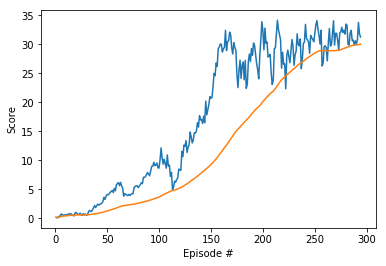

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(rolling_average_score)+1), rolling_average_score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# Here you can test the performance of the agents 

# load the actor critic models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent.actor_local.load_state_dict(torch.load("checkpoints/checkpoint_actor_local.pth", map_location=device))
agent.critic_local.load_state_dict(torch.load("checkpoints/checkpoint_critic_local.pth", map_location=device))

for i in range(10):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
# close the enviroment
env.close()

### As you can see, the average reward is reached after 294 episodes and there are several approaches to improve the results and train the agents much faster:

1- Prioritized experience replay

2- Modification of the hyperparameters which play a crucial role

3- Use of another algorithm such as A3C.
